In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import binom
from scipy.stats import poisson
from sklearn.metrics import mean_squared_error
import pandas as pd
import h5py

In [2]:
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

##### User Parameters

In [3]:
NAME_FILE = '5k_pbmc_v3_molecule_info'  # name of h5 file (exclude ".h5")
PCR = 12  # number of amplification PCR cycles

N_cells = 5025  # Enter expected number of cells (eg. 5000 for 5k_pbmc)

In [4]:
used_topn = False

##### Fast Combination Function  (Much faster than math.comb)

In [5]:
#Combinationequation(Returns"LOGVALUE"ofcomb)
def comb(n,k):
    """
    AfastwaytocalculatebinomialcoefficientsbyAndrewDalke(contrib).
    """
    if 0<=k<=n:
        ntok=1
        ktok=1
        for t in range(1,min(k,n-k)+1):
            ntok+=math.log(n)
            ktok+=math.log(t)
            n-=1
        return ntok - ktok
    else:
        return -1000


In [6]:
# EFFECT: same, but faster than, binom.pmf(x,n,r)
def fast_binom(x,n,r):  # eg. binom(x=1, n=1000 copies, r=0.001 capture rate)
    return math.exp(comb(n,x)) * r**x * (1-r)**(n-x)

# Galton-Watson Branching 

Assume p(amp) = 0.9
<br>
Then: 
<br>
> G1(z) = 0.1 + 0.9z
<br>
G2(z) = 0.1 * G1(z) + 0.9z * G1(z) 
<br>
= (0.01 + 0.09z) + (0.09z + 0.81z^2)
<br>
= 0.01 + 0.18z + 0.81z^2
<br><br>
z = 1 suc. cycle, z^2 = 2 suc. cycle, z^3 = 3 suc. ...

After 2 iterations (PCR cycles),
> P(0 successful cycle) = 0.01  <br>
P(1 suc. cycle) = 0.18 <br>
P(2 suc. cycles) = 0.81

### Recursion Equation

##### Prob. that there are eg. k=4 molecules at eg. cycle n=3  (max 2^n=8 molecules)

Parameters:
> n = number of PCR cycles
<br>
k = number of molecules
<br>
E = prob. of successfuly doubling each PCR cycle

In [7]:
# Make recursion faster via using cache  (avoid repitive calculation)
from functools import lru_cache

@lru_cache(maxsize=None)
def P_k(n, k, E):  # n = number of PCR cycles, k = eg. 400 copies, E = eg. 0.9 capture efficiency
    if n==0:  # if cycle 0, then return 1 molecule
        if k==1:
            return 1
        else:
            return 0
    else:
        sum_pk = 0
        for j in range(int(k/2),k+1):
            sum_pk += math.exp(comb(j,k-j) + math.log(E)*(k-j) + math.log(1-E)*(2*j-k)) * P_k(n-1,j,E)
        return sum_pk

In [8]:
P_k(8,100,0.9)

0.0032075060910953233

### 0. Import Real Data

In [9]:
# # only for 2017
# with h5py.File(NAME_FILE+'.h5', 'r') as hdf:  # 'r' = reading mode
#     ls = list(hdf.keys())  # bring keys from "key-value pairs" in the h5 file
#     print(ls)
    
#     data = hdf.get('reads')
#     count = np.array(data)
#     print('reads\n', count)

In [10]:
with h5py.File(NAME_FILE+'.h5', 'r') as hdf:  # 'r' = reading mode
    ls = list(hdf.keys())  # bring keys from "key-value pairs" in the h5 file

    data = hdf.get('count')
    count = np.array(data)
    print('counts\n', count)
    print('how many UMIs: \n ', len(count))

counts
 [4 3 1 ... 3 7 1]
how many UMIs: 
  48743599


Original Graph

y=0: 0
y=1: 11933832
y=2: 6859586
y=3: 5943973
y=4: 5362247
y=5: 4683703
y=6: 3892260
y=7: 3060415
y=8: 2291548
y=9: 1635081
y=10: 1120566


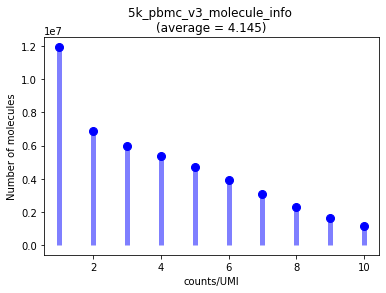

In [11]:
# store how many UMI has counts of eg. y=1 count, y=2 count...  (eg. For x=1, there are 13431 UMIs)
y_org = np.arange(0, 11)
for i in y_org:
    y_org[i] = np.count_nonzero(count == i)  # counts number of "eg. i=3" in array "count"
    print(f'y={i}: {y_org[i]}')

# Plot
fig, ax = plt.subplots(1, 1)

x = np.arange(0, 11)  # x-axis: count of UMI  (x=1 means 1 count)

ax.plot(x[1:], y_org[1:], 'bo', ms=8)
ax.vlines(x[1:], 0, y_org[1:], colors='b', lw=5, alpha=0.5)

plt.xlabel('counts/UMI')
plt.ylabel('Number of molecules')
plt.title(f"{NAME_FILE} \n(average = {round(np.average(count), 3)})")
plt.show()

### (Optional) Top N Barcodes

Takes the top eg. 5000 barcodes of the original data, eg. "5k pbmc".  
<br>
*Why do this?*  
Since 1 barcode represents 1 cell, there should be 5k barcodes for 5k pbmc cells. Correct? Ideally yes, in reality no. I detected over 250k barcodes for 5k pbmc cells. Holy crap! Yes, there is some "crap" in the data which I will remove, via taking the top 5k barcodes with most UMI reads.

In [12]:
# # For 2017 only
# import h5py
# with h5py.File(NAME_FILE+'.h5', 'r') as hdf:  # 'r' = reading mode
#     ls = list(hdf.keys())  # bring keys from "key-value pairs" in the h5 file

#     data = hdf.get('barcode')
#     count_bc = np.array(data)
#     print('barcode\n', count_bc)
#     print('how many UMIs: \n ', len(count_bc))

In [13]:
with h5py.File(NAME_FILE+'.h5', 'r') as hdf:  # 'r' = reading mode
    ls = list(hdf.keys())  # bring keys from "key-value pairs" in the h5 file
    
    data = hdf.get('barcode_idx')
    count_bc = np.array(data)
    print('barcode index\n', count_bc)

barcode index
 [      0       2       2 ... 6794867 6794869 6794877]


Store "UMI/barcode" in a dictionary

In [14]:
barcodes = dict()

for i in tqdm(range(len(count_bc))):
    if count[i]==0: # ignore if count is 0 (useful only for 2017 data)
        continue
        
    idx = count_bc[i]
    
    if idx not in barcodes:  # Add the barcode index to hash table if it's not there
        barcodes[idx] = 1
    else:
        barcodes[idx] += 1  # If eg. barcode_idx = 8 is already there, then just increment its count

used_topn = True

  0%|          | 0/48743599 [00:00<?, ?it/s]

In [15]:
len(barcodes)

891743

Sort. (1) Convert Dictionay -> List, (2) List -> sort in DESCEDING order by "number of UMIs" per barcode
<br><br>
(Eg. i=50 will be the 50th most abundant barcode)

In [16]:
import operator
newA = sorted(barcodes.items(), key=operator.itemgetter(1), reverse=True)[:N_cells]
print(f'The {N_cells}th cell has :', newA[N_cells-1])

The 5025th cell has : (5824516, 578)


Take top N barcodes. Ignore all other barcodes by **turning their reads to 0**.

In [17]:
# Make count[5] = 0 if the barcodes for UMI of index 5 is not the top 1222 barcodes
umi_out = 0  # number of UMIs skipped
for i in trange(len(count)):
    if count_bc[i] not in barcodes:  # required for 2017 data
        continue
    if barcodes[count_bc[i]] < newA[N_cells-1][1]:  # if not top 1222 barcodes with most UMI counts, then skip it via making its counts to 0
        count[i] = 0
        umi_out += 1
        
y_org_topn = np.arange(1, 11)
for i in y_org_topn:
    y_org_topn[i-1] = np.count_nonzero(count == i)  # counts number of "eg. i=3" in array "count"
    print(f'y={i}: {y_org_topn[i-1]}')
    
y_org_topn = np.concatenate([np.array([0]), y_org_topn])

  0%|          | 0/48743599 [00:00<?, ?it/s]

y=1: 7964631
y=2: 6317560
y=3: 5677029
y=4: 5154478
y=5: 4507761
y=6: 3747273
y=7: 2947083
y=8: 2206419
y=9: 1574483
y=10: 1079101


In [18]:
y_org_topn

array([      0, 7964631, 6317560, 5677029, 5154478, 4507761, 3747273,
       2947083, 2206419, 1574483, 1079101])

Original vs Top N barcodes

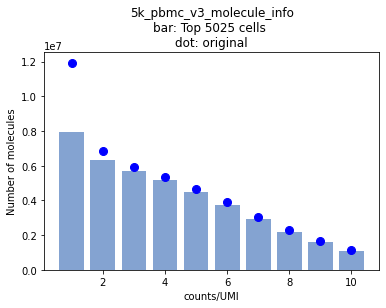

In [19]:
# Plot
fig, ax = plt.subplots(1, 1)

x = np.arange(1, 11)  # x-axis: count of UMI  (x=1 means 1 count)


ax.bar(x, y_org_topn[1:], color=(0.2,0.4,0.7,0.6))
ax.plot(x, y_org[1:], 'bo', ms=8)

plt.xlabel('counts/UMI')
plt.ylabel('Number of molecules')
plt.title(f"{NAME_FILE}\nbar: Top {N_cells} cells \ndot: original")
plt.show()

### Remove ones & convert to PDF -> sum(y)=1

Since I assumed you ran the above "Top N Barcodes" functions, I will keep using the variable name "y_org_topn". In case you haven't, which is totally fine too, I will let this variable equal to the original data. It will still work either way.

In [20]:
if used_topn == False:
    y_org_topn = np.copy(y_org)
y_org_topn

array([      0, 7964631, 6317560, 5677029, 5154478, 4507761, 3747273,
       2947083, 2206419, 1574483, 1079101])

Remove ones, and convert to PDF

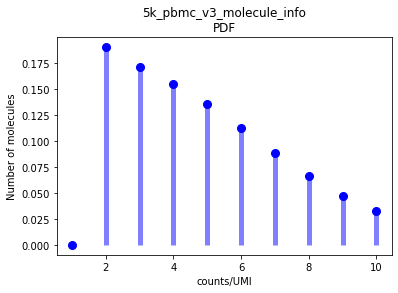

In [21]:
# Find sum(y) of y_org_topn distribution
area_org = 0
for i,v in enumerate(y_org_topn):
    area_org += v 

# 1. Convert to PDF (Divide by area)
y_org_pdf_with_ones=[v/area_org for v in y_org_topn]

# 2. Remove ones
y_org_pdf=[v/(1-y_org_pdf_with_ones[1]) for v in y_org_pdf_with_ones]  # Re-scale such that sum(y[2 to n]) = 1
y_org_pdf[1] = 0

# Plot
fig, ax = plt.subplots(1, 1)
x = np.arange(1, 11)  # x-axis: count of UMI  (x=1 means 1 count)

ax.plot(x, y_org_pdf[1:], 'bo', ms=8)
ax.vlines(x, 0, y_org_pdf[1:], colors='b', lw=5, alpha=0.5)

plt.xlabel('counts/UMI')
plt.ylabel('Number of molecules')
plt.title(f"{NAME_FILE}\nPDF")
plt.show()

### 0. Find 'r' assuming E=100%
> r = capture rate (r=0.01 means it captures 1/100 duplicates in average)  
E = amp. efficiency  (E=100% means every PCR cycle is successful 100% of the time)

Since the capturing process in a sequencing machine can be modelled as a **bernoulli trial**, we can use a **binomial distribution** with E[x] = np to approximate the original data distribution. Here, we will call p as 'r', thus E[x] = nr.

1. Find E[x] of original data  (Note: Since we don't know proportion of zeros, we will always **overestimate average**. There is no way of accurately accounting for this now, so I will try lowering this "overestimated average" later on.

In [22]:
E_x_org = 0
for i,v in enumerate(y_org_pdf_with_ones):
    if i>0:
        E_x_org += i*v
print(E_x_org)

4.043962963893031


2. Find r  (r = E[x]/n) 

In [23]:
n = 2**PCR  # total number of amplified copies
r_max = E_x_org/n
print(r_max)

0.000987295645481697


3. Plot binomial distribution with n, r:

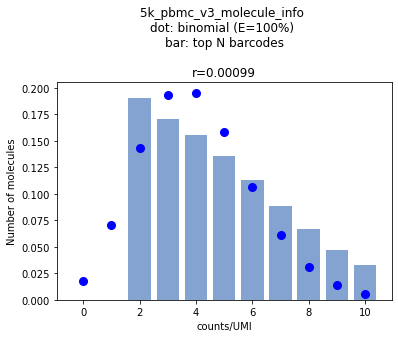

In [24]:
# Plot
fig, ax = plt.subplots(1, 1)

x = np.arange(11)  # x-axis: count of UMI  (x=1 means 1 count)

ax.bar(x, y_org_pdf, color=(0.2,0.4,0.7,0.6)) # original
ax.plot(x, binom.pmf(x,n,r_max), 'bo', ms=8)  # estimate

plt.xlabel('counts/UMI')
plt.ylabel('Number of molecules')
plt.title(f"{NAME_FILE} \ndot: binomial (E=100%) \nbar: top N barcodes\n\nr={round(r_max,5)}")
plt.show()

### 1. Family Size F  (Update E)

Given 4 cycles & E=0.4, construct F[1 to 16 copies]  
Eg. F[k=10 copies] = 0.0032 

In [25]:
df = pd.read_csv('FamilySize'+str(PCR)+'.tsv', sep='\t')
df.head()

,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,...,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.540360,0.475920,0.418596,0.367666,0.322475,0.282430,0.246990,0.215671,0.188032,0.163675,...,2.322183e-07,1.500946e-07,9.542896e-08,5.960464e-08,3.652035e-08,2.191462e-08,1.285500e-08,7.355828e-09,4.096000e-09,2.213315e-09
2,0.261443,0.265341,0.261692,0.252704,0.240093,0.225181,0.208973,0.192224,0.175489,0.159169,...,8.293508e-07,5.559060e-07,3.670344e-07,2.384186e-07,1.521681e-07,9.528097e-08,5.843183e-08,3.502775e-08,2.048000e-08,1.164903e-08
3,0.115625,0.135051,0.149123,0.158036,0.162316,0.162649,0.159767,0.154376,0.147124,0.138576,...,1.295859e-06,8.754420e-07,5.825941e-07,3.814696e-07,2.454324e-07,1.549284e-07,9.578988e-08,5.789711e-08,3.413333e-08,1.957819e-08
4,0.049012,0.065919,0.081531,0.094862,0.105359,0.112823,0.117319,0.119088,0.118475,0.115876,...,2.371270e-06,1.647264e-06,1.129149e-06,7.629390e-07,5.075345e-07,3.319703e-07,2.131730e-07,1.341569e-07,8.258064e-08,4.960542e-08


In [26]:
# Input: (1) E = 0.4 means 40% amp. efficiency
# Effect: Outputs family size "F" by importing it from tsv file
def famsize(E: float)->list:
    return df[str(E)].tolist()

### 2. Apply to Binomial Model

Eg.
 
> P(x=1) += P(k=1 copies) * binom(x=1, N=1 copies, r_constant)
<br>
...<br><br>
P(x=1) += P(k=400 copies) * binom(x=1, N=400 copies, r_constant)
<br>
...<br><br>
P(x=1) += P(k=1024 copies) * binom(x=1, N=1024 copies, r_constant)

(Below) I used poisson to estimate binomial. But you can change this back to binomial via using parameters "r".

In [27]:
# Input: (1) P = [0]*10, (2) r = capture rate, (3) E = amp. efficiency
# Effect: updates input "P" which is our estimate pdf
def update_est(P: list, r: float, E: float, F: list, PCR: int):
    if r < 1:
        MAX_COPIES = 2**PCR
        for x in range(len(P)):  # eg. x=3 means 3 copies/UMI
            for k in range(1,MAX_COPIES+1):
                P[x] += F[k] * fast_binom(x,k,r)
    else:
        print('r exceeded 100%!')

### 3. Update scale of original data distribution

In [28]:
# Changes: nothing
# Effect: returns new list "y_org_pdf_scaled" such that y_org_pdf_scaled[2 to n] == P[2 to n] == eg 0.72 < 1
def update_scale(y_org_pdf: list, P: list)->list:
    area = 0 # sum of P[1 to n]
    for v in P[2:]:
        area+=v
    
    y_org_pdf_scaled = [x*area for x in y_org_pdf]
    
    return y_org_pdf_scaled

# main()  <- Super Important

I mentioned above, that it is **impossible to calculate r**. However, we know the upper bound of r, which we have as "r_max." Thus for each cycle of E, we will keep **decreasing r** until the loss rate stops improving.  
<br>
What's the point?  
By doing this, we can find a better "r" with **lower loss**.

In [29]:
tuples = [] # store tuples (E, loss, r)

# Try ALL possible E
Elist = [v/100 for v in list(range(20,55,1))]  # [0.3, 0.31, 0.32..., 0.99]
for E in tqdm(Elist):
    # 1. update F
    F = famsize(E) # Family size, eg. F[1 to 4096]
    
    # update r 
    r_new_max = r_max * (2/(1+E))**PCR  # If E=100%, r_new==r. If E=0%, r_new==r*(2^PCR)
    r_new = r_new_max
    if r_new >= 1: # ignore if r > 1
        continue
        
    loss_r = [(1,999), (1,998)] # store tuples (r, loss)
    i = 1
    while loss_r[i][1] < loss_r[i-1][1]: # while "new loss" < "last loss" -> stop when it stops improving 
        # 2. update P  (our estimate pdf)
        P = np.zeros(11)  # P[x=2] = is the probability of capturing 2 copies
        update_est(P,r_new,E,F,PCR)

        # 3. update scale of original data distrbution
        y_org_pdf_scaled = update_scale(y_org_pdf,P)

        # 4. Calculate and store loss funtion
        loss = mean_squared_error(y_org_pdf_scaled[2:],P[2:])
        loss_r.append((r_new,loss))
        
        # decrease r
        r_new -= r_new_max*0.02
        i += 1
    
    print(loss_r)
    # Store (E, MIN loss, r)
    if r_new < 1:
        tuples.append((E,loss_r[i-1][1],loss_r[i-1][0]))
    
# Find E with minimum loss
E_pair = min(tuples, key=lambda t:t[1])
E = E_pair[0]
loss = E_pair[1]
r_new = E_pair[2]

  0%|          | 0/35 [00:00<?, ?it/s]

[(1, 999), (1, 998), (0.45355735810311976, 0.00011162521139166065), (0.44448621094105734, 0.00013320105863199358)]
[(1, 999), (1, 998), (0.4105657581779451, 0.00010016464771707289), (0.4023544430143862, 0.00012057234926096443)]
[(1, 999), (1, 998), (0.37195397253406093, 9.058726522806746e-05), (0.3645148930833797, 0.00011000297474419676)]
[(1, 999), (1, 998), (0.3372452428231766, 8.249140125504629e-05), (0.3305003379667131, 0.00010106186950228362)]
[(1, 999), (1, 998), (0.3060179824522314, 7.557415743024207e-05), (0.29989762280318677, 9.342250958901652e-05)]
[(1, 999), (1, 998), (0.2778990188184929, 6.960472429518726e-05), (0.27234103844212304, 8.683497291457946e-05)]
[(1, 999), (1, 998), (0.2525577082815757, 6.440559623344943e-05), (0.2475065541159442, 8.11061921115393e-05)]
[(1, 999), (1, 998), (0.22970080543797805, 5.983916616104113e-05), (0.2251067893292185, 7.608581275870443e-05)]
[(1, 999), (1, 998), (0.20906798510092464, 5.579804015074503e-05), (0.20488662539890615, 7.1655940630

In [30]:
tuples  # (E, loss, r) E: amplification efficiency, r: capture rate

[(0.2, 0.00011162521139166065, 0.45355735810311976),
 (0.21, 0.00010016464771707289, 0.4105657581779451),
 (0.22, 9.058726522806746e-05, 0.37195397253406093),
 (0.23, 8.249140125504629e-05, 0.3372452428231766),
 (0.24, 7.557415743024207e-05, 0.3060179824522314),
 (0.25, 6.960472429518726e-05, 0.2778990188184929),
 (0.26, 6.440559623344943e-05, 0.2525577082815757),
 (0.27, 5.983916616104113e-05, 0.22970080543797805),
 (0.28, 5.579804015074503e-05, 0.20906798510092464),
 (0.29, 5.219795840864002e-05, 0.19042792972468253),
 (0.3, 4.8972565156955825e-05, 0.17357490723522548),
 (0.31, 4.606950552612641e-05, 0.15832577466294245),
 (0.32, 4.344748546727914e-05, 0.14451735189094608),
 (0.33, 4.1074037908813506e-05, 0.132004117463987),
 (0.34, 3.8923812049631565e-05, 0.12065618494150068),
 (0.35, 3.69772538768283e-05, 0.11035752388704469),
 (0.36, 3.521958195517927e-05, 0.10100439440319495),
 (0.37, 3.3639988050161945e-05, 0.09250396826241593),
 (0.38, 3.223101042313909e-05, 0.08477311324924731

### Real vs Simulator  (Run with 10x_Template_for_counts...) 

Update P (estimate) with E_min

In [33]:
# 1. update F
F = famsize(E)  

# 2. update P  (our estimate pdf)
P = np.zeros(11)  # P[x=2] = is the probability of capturing 2 copies
update_est(P,r_new,E,F,PCR)

# 3. update scale of origina data graph
y_org_pdf_scaled = update_scale(y_org_pdf,P)

loss = mean_squared_error(y_org_pdf_scaled[2:],P[2:])

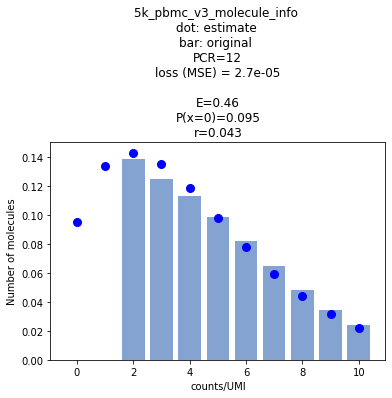

In [35]:
# Plot
fig, ax = plt.subplots(1, 1)

x = np.arange(0, 11)  # x-axis: count of UMI  (x=1 means 1 count)

ax.bar(x, y_org_pdf_scaled, color=(0.2,0.4,0.7,0.6))
ax.plot(x, P, 'bo', ms=8)

plt.xlabel('counts/UMI')
plt.ylabel('Number of molecules')
plt.title(f"{NAME_FILE} \ndot: estimate \nbar: original \nPCR={PCR}\nloss (MSE) = {round(loss,8)}\n\nE={E}\nP(x=0)={round(P[0],3)}\nr={round(r_new,3)}")
plt.show()

In [36]:
# Average
sum1=0
for i,v in enumerate(P):
    sum1+=i*v
print(f'av including zeros: {sum1}')
print(f'P[x=0]={P[0]}')

av including zeros: 3.527159619158477
P[x=0]=0.09517518799454584
